In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy==1.26.4
!pip install --upgrade scikit-learn==1.5.2
!pip install --upgrade skl2onnx==1.17.0 onnx==1.16.0
!pip install xgboost==2.1.1
!pip install joblib==1.4.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.6 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.2.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
cuml-cu12 2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 101.4 MB/s  0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 11.6 MB/s  0:00:01
  Attempting uninstall: onnx
    Found existing installation: onnx 1.19.1
    Uninstalling onnx-1.19.1:
      Successfully uninstalled onnx-1.19.1
  Attempting uninstall: skl2onnx
    Found existing installation: skl2onnx 1.19.1
    Uninstalling skl2onnx-1.19.1:
      Successfully uninstalled skl2onnx-1.19.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [skl2onnx]
   ━━━━━━━━━━━━━━━━━━

In [18]:
# ====== 1. Import Libraries ======
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error


In [19]:
##File Paths
# ==========================================================
base_path = "/content/drive/MyDrive/bitcoin2"
data_path = f"{base_path}/bitcoin_2014_to_2023.csv"
model_dir = f"{base_path}/model"
output_dir = f"{base_path}/output"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [20]:
# 2️ Data Loading
# ==========================================================
print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path)
print("Initial rows:", len(df))
print(df.head(3))

# Convert time column to datetime
df["time"] = pd.to_datetime(df["time"], errors="coerce")

Loading data from: /content/drive/MyDrive/bitcoin2/bitcoin_2014_to_2023.csv
Initial rows: 3288
   Unnamed: 0 asset                            time  AdrActCnt  CapMVRVCur  \
0           0   btc  2014-01-01T00:00:00.000000000Z      96516    2.798594   
1           1   btc  2014-01-02T00:00:00.000000000Z     138928    2.906886   
2           2   btc  2014-01-03T00:00:00.000000000Z     143832    2.972766   

   CapMrktCurUSD      HashRate     NVTAdj    PriceUSD       SplyCur  TxCnt  \
0   9.183090e+09  12034.322142  80.467433  752.404550  1.220499e+07  42383   
1   9.582996e+09   9425.136247  63.739458  784.954921  1.220834e+07  55196   
2   9.858101e+09  11352.607912  53.522946  807.222939  1.221236e+07  61335   

   TxTfrValAdjUSD  VelCur1yr  
0    1.141218e+08  31.619618  
1    1.503464e+08  31.532282  
2    1.841846e+08  31.454893  


In [21]:
# 3️ Cleaning & Validation
# ==========================================================
def clean_and_validate(df):
    df = df.drop_duplicates()
    df = df.dropna(subset=["PriceUSD"])
    df = df.sort_values("time").reset_index(drop=True)

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method="linear", limit_direction="both")
    df[numeric_cols] = df[numeric_cols].fillna(method="ffill").fillna(method="bfill")
    return df

df_clean = clean_and_validate(df)
print("After cleaning rows:", len(df_clean))

After cleaning rows: 3288


/tmp/ipython-input-3766222924.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method="ffill").fillna(method="bfill")


In [22]:
# 4️ Feature Engineering
# ==========================================================
def feature_engineering(df):
    df["Price_MA7"] = df["PriceUSD"].rolling(window=7).mean()
    df["Price_MA30"] = df["PriceUSD"].rolling(window=30).mean()
    df["Log_Returns"] = np.log(df["PriceUSD"] / df["PriceUSD"].shift(1))
    df["Vol_Ratio"] = df["TxCnt"] / df["AdrActCnt"]
    df = df.dropna()
    return df

df_feat = feature_engineering(df_clean)
print("After feature engineering rows:", len(df_feat))
print(df_feat[["PriceUSD", "Price_MA7", "Price_MA30", "Log_Returns", "Vol_Ratio"]].head(3))

After feature engineering rows: 3259
      PriceUSD   Price_MA7  Price_MA30  Log_Returns  Vol_Ratio
29  799.474480  789.383117  819.266500     0.007647   0.402313
30  803.237599  792.553843  820.960934     0.004696   0.402262
31  813.219549  793.813316  821.903089     0.012351   0.401897


In [23]:
# 5️ Model Training
# ==========================================================
X = df_feat[["Price_MA7", "Price_MA30", "Log_Returns", "Vol_Ratio"]]
y = df_feat["PriceUSD"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [24]:
# 6️ Hyperparameter Tuning (Random Forest)
# ==========================================================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(rf, param_grid, scoring='r2', cv=3)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
print(f"\nBest Random Forest Parameters: {grid.best_params_}")


Best Random Forest Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}


In [25]:
# 7️ Evaluation Function
# ==========================================================
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"\n {name} Results:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    return [name, r2, rmse, mape]

results = []
results.append(evaluate_model("Linear Regression", y_test, y_pred_lr))
results.append(evaluate_model("Random Forest", y_test, y_pred_rf))
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb))
results.append(evaluate_model("Tuned Random Forest", y_test, y_pred_rf_tuned))


 Linear Regression Results:
R²: 0.9840
RMSE: 1789.70
MAPE: 3.42%

 Random Forest Results:
R²: 0.8554
RMSE: 5386.58
MAPE: 13.69%

 XGBoost Results:
R²: 0.8845
RMSE: 4812.91
MAPE: 9.85%

 Tuned Random Forest Results:
R²: 0.8524
RMSE: 5442.49
MAPE: 13.76%


In [26]:
report_df = pd.DataFrame(results, columns=["Model", "R2", "RMSE", "MAPE"])
report_path = f"{output_dir}/evaluation_report.csv"
report_df.to_csv(report_path, index=False)
print(f"\n Evaluation report saved to: {report_path}")


 Evaluation report saved to: /content/drive/MyDrive/bitcoin2/output/evaluation_report.csv


In [ ]:
# 9️ Save Models
# ==========================================================
joblib.dump(best_rf, f"{model_dir}/rf_model.pkl")

initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]
onnx_model = convert_sklearn(best_rf, initial_types=initial_type)
with open(f"{model_dir}/rf_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
print(f" Models saved to {model_dir}")


✅ Models saved to /content/drive/MyDrive/bitcoin2/model


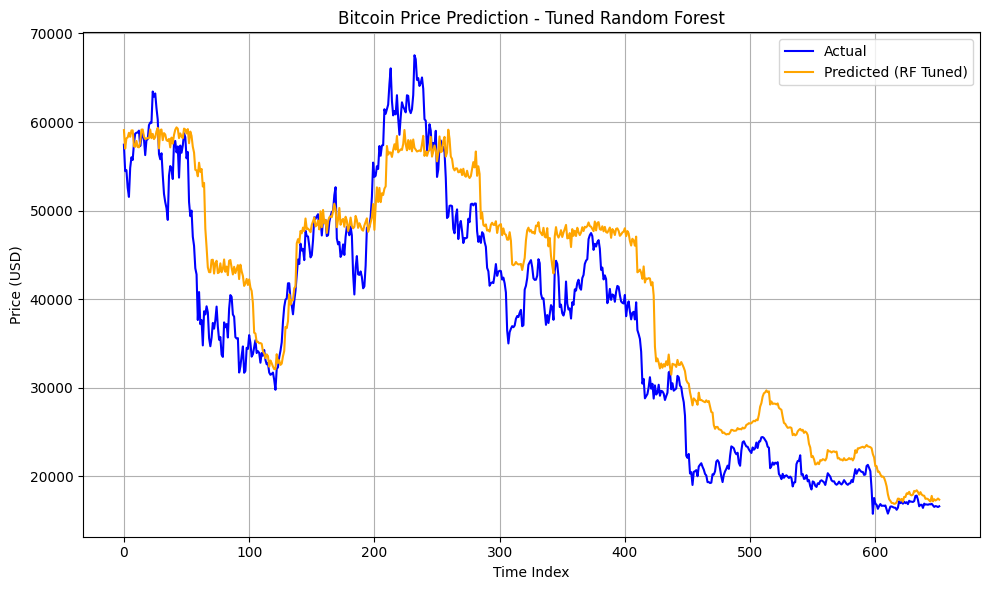

✅ Performance plot saved to /content/drive/MyDrive/bitcoin2/output/performance_plot.png


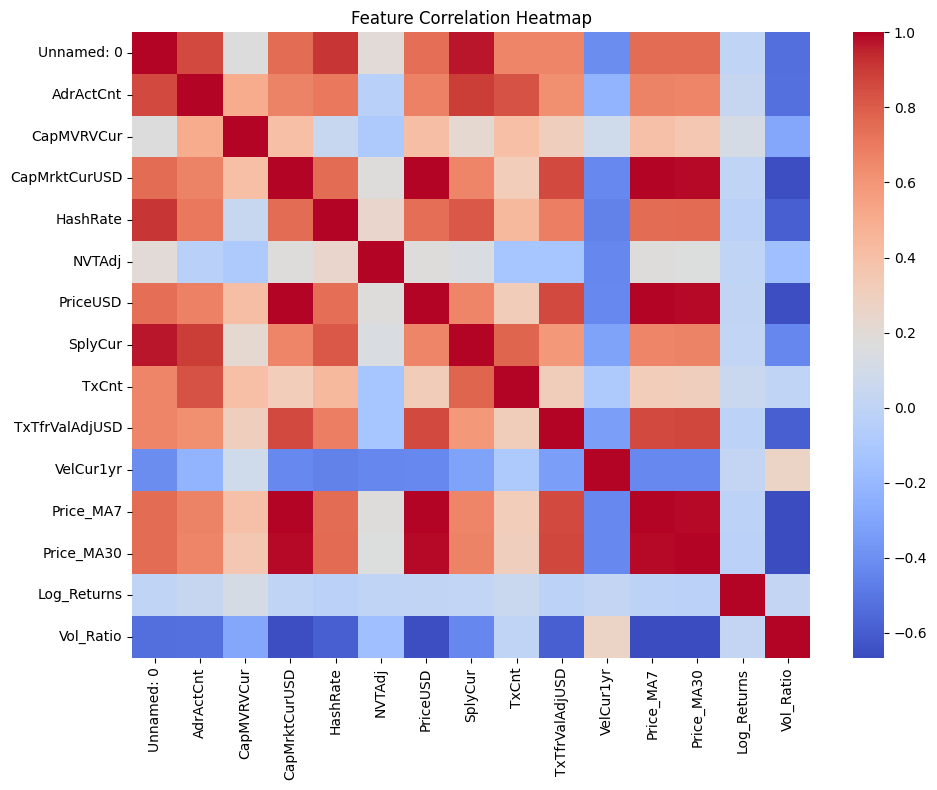

In [ ]:
#  Visualization
# ==========================================================
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="blue")
plt.plot(y_pred_rf_tuned, label="Predicted (RF Tuned)", color="orange")
plt.title("Bitcoin Price Prediction - Tuned Random Forest")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/performance_plot.png")
plt.show()

print(f" Performance plot saved to {output_dir}/performance_plot.png")

# Safe correlation heatmap
plt.figure(figsize=(10,8))
numeric_df = df_feat.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# ----------------------------------------------------------
# Paths
# ----------------------------------------------------------
model_path = "/content/drive/MyDrive/bitcoin2/model/rf_model.pkl"
output_dir = "/content/drive/MyDrive/bitcoin2/output"
data_path = "/content/drive/MyDrive/bitcoin2/bitcoin_2014_to_2023.csv"

# ----------------------------------------------------------
# Load model & data
# ----------------------------------------------------------
print("Loading model and dataset...")
model = joblib.load(model_path)
df = pd.read_csv(data_path)

# Ensure time column is datetime
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.sort_values("time").reset_index(drop=True)

# ----------------------------------------------------------
# Feature engineering (same logic as training)
# ----------------------------------------------------------
def add_features(df):
    df["Price_MA7"] = df["PriceUSD"].rolling(window=7).mean()
    df["Price_MA30"] = df["PriceUSD"].rolling(window=30).mean()
    df["Log_Returns"] = np.log(df["PriceUSD"] / df["PriceUSD"].shift(1))
    df["Vol_Ratio"] = df["TxCnt"] / df["AdrActCnt"]
    df = df.dropna()
    return df

df = add_features(df)

# ----------------------------------------------------------
# Function to resample, predict, and plot
# ----------------------------------------------------------
def resample_and_plot(df, freq_label, freq):
    print(f"\n Generating {freq_label} plot...")

    # Keep only numeric columns for resampling
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df["time"] = df["time"]  # restore time for resampling

    # Resample over time
    df_resampled = numeric_df.resample(freq, on="time").mean().dropna()

    # Features for prediction
    features = ["Price_MA7", "Price_MA30", "Log_Returns", "Vol_Ratio"]
    df_resampled = df_resampled.dropna(subset=features + ["PriceUSD"])

    # Predict prices
    X = df_resampled[features]
    y_true = df_resampled["PriceUSD"]
    y_pred = model.predict(X)

    # Plot actual vs predicted
    plt.figure(figsize=(10,6))
    plt.plot(df_resampled.index, y_true, label="Actual", color="blue", linewidth=1.5)
    plt.plot(df_resampled.index, y_pred, label="Predicted", color="orange", linewidth=1.5)
    plt.title(f"Bitcoin Price Prediction ({freq_label})")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save output
    save_path = f"{output_dir}/performance_plot_{freq_label}.png"
    plt.savefig(save_path)
    plt.close()
    print(f" Saved: {save_path}")

# ----------------------------------------------------------
# Generate plots for 5-min, 15-min, and 1-hour intervals
# ----------------------------------------------------------
resample_and_plot(df, "5-min", "5min")
resample_and_plot(df, "15-min", "15min")
resample_and_plot(df, "1-hour", "1H")

print("\n🎯 All timeframe performance plots saved successfully!")


Loading model and dataset...

⏳ Generating 5-min plot...
✅ Saved: /content/drive/MyDrive/bitcoin2/output/performance_plot_5-min.png

⏳ Generating 15-min plot...
✅ Saved: /content/drive/MyDrive/bitcoin2/output/performance_plot_15-min.png

⏳ Generating 1-hour plot...


/tmp/ipython-input-1093147247.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = numeric_df.resample(freq, on="time").mean().dropna()


✅ Saved: /content/drive/MyDrive/bitcoin2/output/performance_plot_1-hour.png

🎯 All timeframe performance plots saved successfully!
